In [2]:
import proteusAI as pai
import pandas as pd

/opt/anaconda3/envs/proteusAI/lib/python3.8/site-packages/proteusAI/ml_tools/esm_tools/esm_tools.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alphabet = torch.load(o

In [3]:
library_pae = pai.Library(source='demo/demo_data/master_dataset.csv', seqs_col='binder_seq', y_col='pae_interaction_HLA-A101-RVTDESILSY', 
                    y_type='num', names_col='binder_name')
library_plddt = pai.Library(source='demo/demo_data/master_dataset.csv', seqs_col='binder_seq', y_col='plddt_binder_HLA-A101-RVTDESILSY', 
                    y_type='num', names_col='binder_name')

In [4]:
model_pae = pai.Model(library=library_pae)
plddt_model = pai.Model(library=library_plddt)

In [5]:
_ = model_pae.train(k_folds=5, model_type='rf', x='blosum62', seed=42, split=(60,20,20))

Training completed:
val_r2:	-0.49498796320514754


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Predicted vs. True y-values'}, xlabel='y', ylabel='predicted y'>)

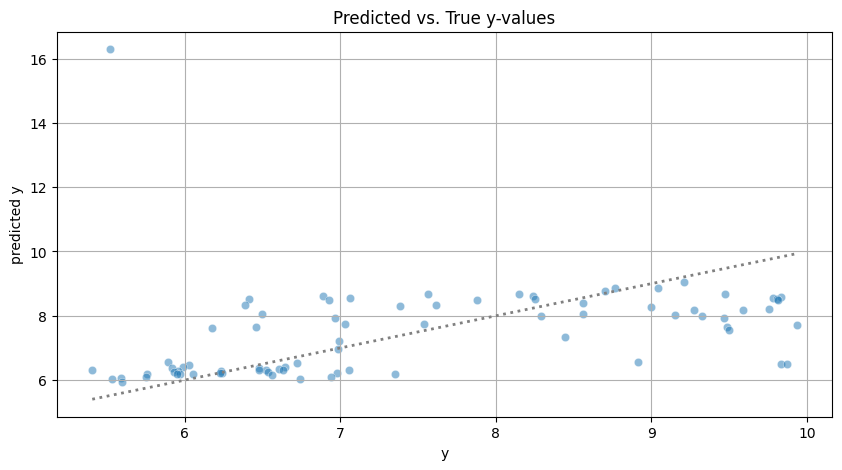

In [6]:
model_pae.true_vs_predicted(y_true=model_pae.y_val, y_pred=model_pae.y_val_pred)

In [7]:
train_names = [prot.name for prot in model_pae.train_data]
test_names = [prot.name for prot in model_pae.test_data]
val_names = [prot.name for prot in model_pae.val_data]

In [8]:
train = [prot for prot in plddt_model.library.proteins if prot.name in train_names]
test = [prot for prot in plddt_model.library.proteins if prot.name in test_names]
val = [prot for prot in plddt_model.library.proteins if prot.name in val_names]

split = {'train':train, 'test':test, 'val':val}

plddt_out = plddt_model.train(k_folds=5, model_type='rf', x='blosum62', seed=42, split=split)

Training completed:
val_r2:	0.29748145490831435


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Predicted vs. True y-values'}, xlabel='y', ylabel='predicted y'>)

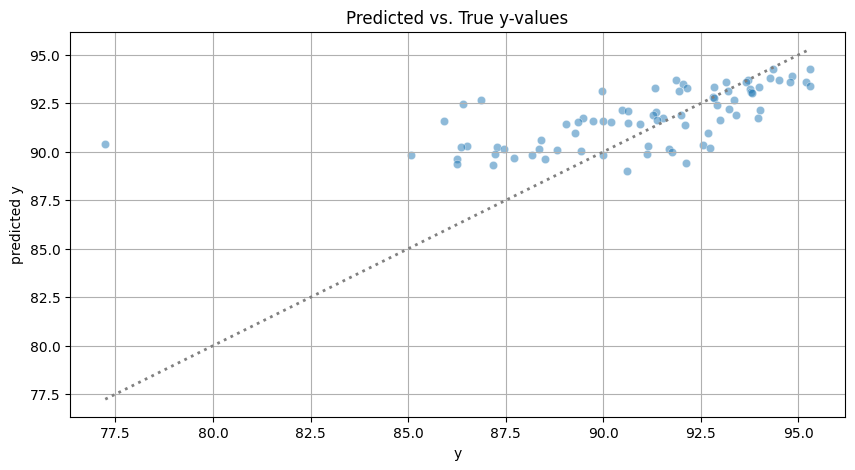

In [9]:
plddt_model.true_vs_predicted(y_true=plddt_model.y_val, y_pred=plddt_model.y_val_pred)

In [10]:
pae_out = model_pae.search(optim_problem='min', overwrite=True) # acq_fn = 'ei'

In [11]:
predicted_proteins = [pai.Protein(seq=row.sequence, name=row['name']) for i, row in pae_out.iterrows()]
plddt_predictions = plddt_model.predict(predicted_proteins)

In [12]:
for prot in plddt_predictions[0]:
    print(prot)
    predicted_plddt_value = prot.y_pred
    predicted_plddt_sigma = prot.y_sigma
    print(predicted_plddt_value, predicted_plddt_sigma)
    break

proteusAI.Protein():
____________________
name	: binder_1+E73S
seq	: EEEEKFKKELEETRKRMLEEARELTARAVEALRAGEELLAQALSNAAGILMTVVSLADNLLLGDLKGAEINLSSMEKLYEILKETAEQLKAKHPEYAPEVEELLKLAEEALKEAKKLLEKAKKL
rep	: []
y:	None
y_pred:	95.02595400000001
y_sig:	0.7905564267679063
struc:	None

95.02595400000001 0.7905564267679063


In [18]:
out_pae = pae_out.sort_values(by=['y_predicted'], ascending=True)
out_pae.to_csv('demo/demo_data/predictions_pae.csv')

array([[<Axes: title={'center': 'y_predicted'}>,
        <Axes: title={'center': 'y_sigma'}>],
       [<Axes: title={'center': 'acq_score'}>, <Axes: >]], dtype=object)

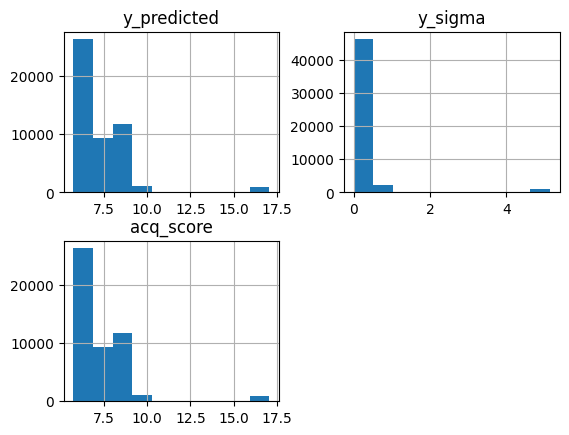

In [19]:
out_pae.hist()